## II-Similation in Bandits Method

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats
import math
%matplotlib inline

### Background

The company is considering raising awareness of the scooter-share program by sending a
person out around your city to hand out promotional flyers to people passing by and answer
questions about your company. <br/>
* The company would like to know what parts of the city to send this person out to. They have a candidate list of intersections, but the idea is that the best intersection to recruit users at could be learned over time. 

<br />There is only one recruiter to hand out flyers, and you can send them to only one intersection every day. The company would like to  
* (a) formulate this as a multi-armed bandits data-acquisition problem, 
* (b) research the feasibility of using the UCB algorithm for placing the flyer-handouts in the city each day by simulating such an approach on the data sets on bikeshares from your previous project, and 
* (c) return this report summarizing your findings and recommendations.

### 1.1 Formalizing the problem as a multi-armed bandits problem

* What are the arms? What are the rewards? Would you model the rewards as subgaussian or as bounded?<br/>
    - Arms: the stations, 
    - Rewards: the quantity of users who start or end a trip at this station on that date.
* What is the time horizon?
    - 2016-01-01 to 2016-12-31.
* What are the modeling assumptions?
    - Every arm has fixed distribution.
    - The rewards(daily usage on each station) is sub-Gaussian.
    - Each arm is independent to each other.
    - If some arm is not supervised on that day, we assume there's no reward on that day.
* Which of your assumptions do you expect to be reasonable? Which might you not expect to hold? Why? Which assumptions can you test by gathering data?
    - The first two assumptions are reasonable, since for certain location, the usage of scooters should subject to a stable distribution.
    - The third assumption may not hold, since scooter usage at each station may not be independent, like the station nearby may be correlated with each other. 
    - The forth assumption may not hold either, since it's very likely there is usage at each station even though it's not the station "been pulled" on that day.
    - With the data, we can easily check if the third assumption hold by calculating the correlations between two stations, and check the forth assumption by looking the number of usage at each station organized by days.
* What notion of regret are you considering? In particular, which strategy (possibly with perfect knowledge) would you compare your adaptive strategy to?
    - Regret is the difference between the reward of the arm I currently pull and reward of if I pull the actual best arm, namely, the regret at time t is, the difference between the "number of rentals at the station I chose at t" and the "number of rentals if I chose the best station".

### 1.2 Simulate UCB strategy using past data

- To start with, I'm assuming a sub-Gaussianity at each station. I instantiate the parameter<br/> of all the stations by giving out flyers at each station for one day, that is, in the first <br/>10 days of the experiment, I'll give out flyers at "station 1" on the 1st day, "station 2" on <br/>the 2nd day,....(i.e pull each arm once). Their performance statistics on the first day of <br/>each arm will be stored as the initial parameters of their distributions.

  
- At each iteration(each day in this case), I updated the average usage of each station(mean of <br/>each arm) by calculating the cumulative means up to that day (i.e, the mean of station_35 at<br/>03-20 will be the mean daily usage of station_35 from 01-01 to 03-19). The upper bounds of <br/>each station will be updated in the algorithm described below. With the upper bounds being <br/>updated, we'll choose where to give out flyers on the next day by selecting the station <br/>that has the highest upper bound so far. The upper confidence bound is generated by the <br/>following formulas, <br/><br/>
For simplicity, I skipped the proofs:<br/><br/>
* $A_t = argmax(\hat\mu_{i} + \sqrt\frac{3\log(t)}{2T_i}   )$ at some time $t > K$, for K = number of stations; <br/><br/>
* $A_t = t$ when $t \leq K$; where $A_t$ represent the Arm pulled at time t.


And we select the station(arm) based on the statistics up to yesterday(pick the arm with highest upper confidence). <br/>Iterate through this process until 2016-12-31.

#### Let's find the 10 stations(arms) in Chicago.csv in this section

In [345]:
## load the data
chi_df = pd.read_csv("../data/bikeshare/chicago.csv")
from_station = chi_df.groupby("from_station_id")["trip_id"].count()
to_station = chi_df.groupby("to_station_id")["trip_id"].count()

In [346]:
station_total = pd.merge(pd.DataFrame(from_station), pd.DataFrame(to_station), left_index=True, right_index=True)
station_total.reset_index(inplace=True)
station_total["station_total"] = station_total["trip_id_x"] + station_total["trip_id_y"]
station_total.columns = ["station_id", "#from_trips", "#to_trips", "station_total"]
print("finish getting total rentals in each station")
#station_total.head(10)

finish getting total rentals in each station


In [347]:
## get the first 10
first_ten = station_total.sort_values(by ='station_total', ascending= False)[:10]
#first_ten = first_ten.reset_index()
print("Ten busiest stations in Chicago")
first_ten

Ten busiest stations in Chicago


,station_id,#from_trips,#to_trips,station_total
31,35,1837,2020,3857
68,76,1011,933,1944
246,268,938,1003,1941
160,177,930,987,1917
79,91,914,908,1822
73,85,799,811,1610
69,77,825,782,1607
78,90,759,810,1569
157,174,740,753,1493
119,133,622,651,1273


####  Now, let's construct df of total rentals of these 10 stations on each day of the year.

In [348]:
chi_df['starttime_pd'] = pd.to_datetime(chi_df['starttime'])
chi_df['date'] = chi_df['starttime_pd'].dt.date
station_list = list(first_ten["station_id"])
curr = chi_df[chi_df["from_station_id"].isin(station_list)]
curr = curr.groupby(["date","from_station_id"])["trip_id"].count()
curr = pd.DataFrame(curr)
temp = pd.pivot_table(curr, index= "date" , values=['trip_id'],columns= ['from_station_id'],aggfunc='sum')
from_station = temp.fillna(0)
#from_station.head()

In [349]:
curr_2 = chi_df[chi_df["to_station_id"].isin(station_list)]
curr_2 = curr_2.groupby(["date","to_station_id"])["trip_id"].count()
curr_2 = pd.DataFrame(curr_2)
temp = pd.pivot_table(curr_2, index= "date" , values=['trip_id'],columns= ['to_station_id'],aggfunc='sum')
to_station = temp.fillna(0)
#to_station.head(6)

In [350]:
temp = pd.pivot_table(curr, index= "date" , values=['trip_id'],columns= ['from_station_id'],aggfunc='sum')
from_station = temp.fillna(0)

temp = pd.pivot_table(curr_2, index= "date" , values=['trip_id'],columns= ['to_station_id'],aggfunc='sum')
to_station = temp.fillna(0)


from_station.columns = [col[0] + "_from_" + str(col[1]) for col in from_station.columns.ravel()]
to_station.columns = [col[0] + "_to_" + str(col[1]) for col in to_station.columns.ravel()]
df = pd.merge(from_station, to_station, left_index = True, right_index = True, how = "outer")
df.fillna(0, inplace = True)

for i in [35, 76, 77, 85, 90, 91, 133, 174, 177, 268]:
    df['sum_col_' + str(i)] = df['trip_id_from_' + str(i)] + df['trip_id_to_' + str(i)]
df = df.iloc[:,20:30]
df.head()

,sum_col_35,sum_col_76,sum_col_77,sum_col_85,sum_col_90,sum_col_91,sum_col_133,sum_col_174,sum_col_177,sum_col_268
date,,,,,,,,,,
2016-01-01,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0
2016-01-02,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2016-01-03,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
2016-01-04,0.0,0.0,4.0,1.0,1.0,6.0,2.0,3.0,0.0,0.0
2016-01-05,0.0,0.0,3.0,1.0,0.0,2.0,2.0,3.0,0.0,0.0


In [351]:
temp = pd.pivot_table(curr, index= "date" , values=['trip_id'],columns= ['from_station_id'],aggfunc='sum')
from_station = temp.fillna(0)

temp = pd.pivot_table(curr_2, index= "date" , values=['trip_id'],columns= ['to_station_id'],aggfunc='sum')
to_station = temp.fillna(0)


from_station.columns = [col[0] + "_from_" + str(col[1]) for col in from_station.columns.ravel()]
to_station.columns = [col[0] + "_to_" + str(col[1]) for col in to_station.columns.ravel()]
df = pd.merge(from_station, to_station, left_index = True, right_index = True, how = "outer")
df.fillna(0, inplace = True)

for i in [35, 76, 77, 85, 90, 91, 133, 174, 177, 268]:
    df['sum_col_' + str(i)] = df['trip_id_from_' + str(i)] + df['trip_id_to_' + str(i)]
df = df.iloc[:,20:30]
df.head(10)

,sum_col_35,sum_col_76,sum_col_77,sum_col_85,sum_col_90,sum_col_91,sum_col_133,sum_col_174,sum_col_177,sum_col_268
date,,,,,,,,,,
2016-01-01,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0
2016-01-02,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2016-01-03,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
2016-01-04,0.0,0.0,4.0,1.0,1.0,6.0,2.0,3.0,0.0,0.0
2016-01-05,0.0,0.0,3.0,1.0,0.0,2.0,2.0,3.0,0.0,0.0
2016-01-06,0.0,0.0,4.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0
2016-01-07,0.0,0.0,2.0,2.0,1.0,5.0,1.0,6.0,0.0,0.0
2016-01-08,0.0,0.0,3.0,0.0,1.0,3.0,1.0,3.0,0.0,0.0
2016-01-09,0.0,0.0,0.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0


### Now, contruct the cum_df, display the cumulative number of rentals of each station up to that day.

In [352]:
cum_df = df.copy()

In [353]:
column_names =  np.array(["sum_col_35","sum_col_76","sum_col_77","sum_col_85","sum_col_90", "sum_col_91","sum_col_133","sum_col_174","sum_col_177","sum_col_268"])

for j in column_names:
    new_col = []
    for i in range(cum_df.shape[0]):
        new_col.append(np.sum(cum_df.iloc[:i+1][j]))
    cum_df[j] = new_col

In [354]:
cum_df.head()

,sum_col_35,sum_col_76,sum_col_77,sum_col_85,sum_col_90,sum_col_91,sum_col_133,sum_col_174,sum_col_177,sum_col_268
date,,,,,,,,,,
2016-01-01,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0
2016-01-02,2.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,2.0,0.0
2016-01-03,2.0,0.0,2.0,0.0,0.0,0.0,1.0,1.0,2.0,1.0
2016-01-04,2.0,0.0,6.0,1.0,1.0,6.0,3.0,4.0,2.0,1.0
2016-01-05,2.0,0.0,9.0,2.0,1.0,8.0,5.0,7.0,2.0,1.0


### Initialize all arms
To initialize all the arms, we pull each arm once, that is, inspect each station one day first. So the in the first 10 days we'll inspect station_35, station_76,.... and finally station_268. We start getting into the regular decision rule in the 11th day.

In [355]:
## on the 11th pull
sta_35 = (2/10) + math.sqrt((3*math.log(10))/2)
sta_76 = (0/10) + math.sqrt((3*math.log(10))/2)
sta_77 = (1/10) + math.sqrt((3*math.log(10))/2)
sta_85 = (1/10) + math.sqrt((3*math.log(10))/2)
sta_90 = (0/10) + math.sqrt((3*math.log(10))/2)
sta_91 = (1/10) + math.sqrt((3*math.log(10))/2)
sta_133 = (1/10) + math.sqrt((3*math.log(10))/2)
sta_174 = (3/10) + math.sqrt((3*math.log(10))/2)
sta_177 = (0/10) + math.sqrt((3*math.log(10))/2)
sta_268 = (0/10) + math.sqrt((3*math.log(10))/2)
upper_bounds_init = np.array([sta_35, sta_76, sta_77, sta_85, sta_90, sta_91, sta_133, sta_174, sta_177, sta_268])
upper_bounds_init

array([2.05846109, 1.85846109, 1.95846109, 1.95846109, 1.85846109,
       1.95846109, 1.95846109, 2.15846109, 1.85846109, 1.85846109])

In [356]:
def update_UCB_arm():
    ## initialize the best reward
    best_reward = 10.56
    
    ### initialize by pulling all arms once
    num_times_pulled = np.array([1,1,1,1,1,1,1,1,1,1])
    pull_record = [num_times_pulled.copy()]
    
    ### the reward got by the first pull
    total_reward_gain = np.array([2,0,1,1,0,1,1,3,0,1])
    
    ### temp helper
    mu_over_time = total_reward_gain/num_times_pulled
    ### mean record
    mean_record = [mu_over_time.copy()]
    
    ### store the initial upper bound, at time 11 
    upper_bounds = mu_over_time + ((math.log(11))/(num_times_pulled))**(1/2)
    upper_bounds_hist = [upper_bounds.copy()]
    
    ### initialize the regret
    regret = 105.6 - 8
    cum_regret = [105.6 - 8]
    
    total_reward = 10
    
    
    ## Start iteration from the 11th pull, index 10
    for i in range(10,365):
        arm_to_pull = np.argmax(upper_bounds)
        num_times_pulled[arm_to_pull] += 1
        ## record
        pull_record.append(num_times_pulled.copy())
        
        total_reward_gain[arm_to_pull] += df.iloc[i ,arm_to_pull] 
        
        total_reward += df.iloc[i ,arm_to_pull]
        
        ## mu to update
        new_mu = (total_reward_gain[arm_to_pull]/num_times_pulled[arm_to_pull])
        mu_over_time[arm_to_pull] = new_mu
        mean_record.append(mu_over_time.copy())
        
        upper_bounds = mu_over_time + ((3*math.log(i+1))/(2*num_times_pulled))**(1/2)
        ##upper_bounds[arm_to_pull] = new_mu + ((3*math.log(i+1))/(2*num_times_pulled[arm_to_pull]*i))**(1/2)
        ## record
        upper_bounds_hist.append(upper_bounds.copy())
        
        if arm_to_pull != 0:
            regret += best_reward - df.iloc[i ,arm_to_pull]
            cum_regret.append(regret)
        else:
            regret += 0
            cum_regret.append(regret)
            
            #cum_regret.append()
    
    return pull_record, mean_record, upper_bounds_hist, cum_regret, total_reward

In [357]:
pull_record, mean_record, upper_bounds_hist, regret_over_time, total_reward = update_UCB_arm()

In [358]:
pull_record = pd.DataFrame(pull_record)
upper_bounds_hist = pd.DataFrame(upper_bounds_hist)
mean_record = pd.DataFrame(mean_record)

In [359]:
## for reference
df.mean(axis = 0) 

sum_col_35     10.567123
sum_col_76      5.326027
sum_col_77      4.402740
sum_col_85      4.410959
sum_col_90      4.298630
sum_col_91      4.991781
sum_col_133     3.487671
sum_col_174     4.090411
sum_col_177     5.252055
sum_col_268     5.317808
dtype: float64

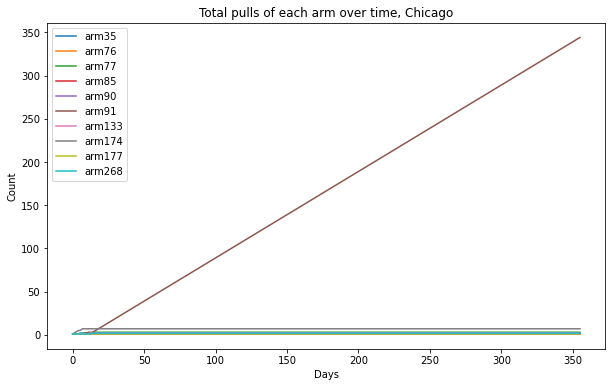

In [360]:
plt.figure(figsize=(10,6))
plt.plot(pull_record)
plt.ylabel("Count")
plt.xlabel("Days")
plt.title("Total pulls of each arm over time, Chicago")
plt.legend(["arm35","arm76","arm77","arm85","arm90","arm91","arm133","arm174","arm177","arm268"])
plt.show()

Text(0.5, 0, 'Days')

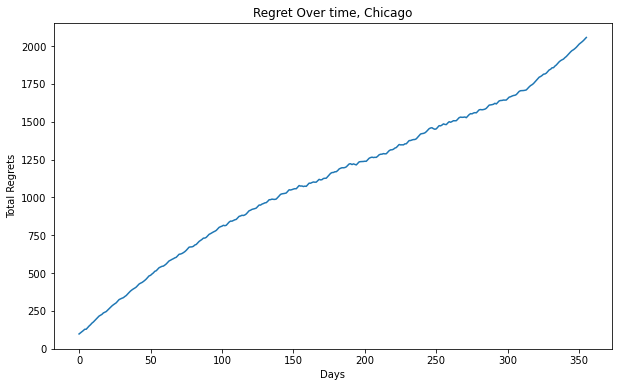

In [361]:
plt.figure(figsize=(10,6))
plt.plot(regret_over_time)
plt.title("Regret Over time, Chicago")
plt.ylabel("Total Regrets")
plt.xlabel("Days")

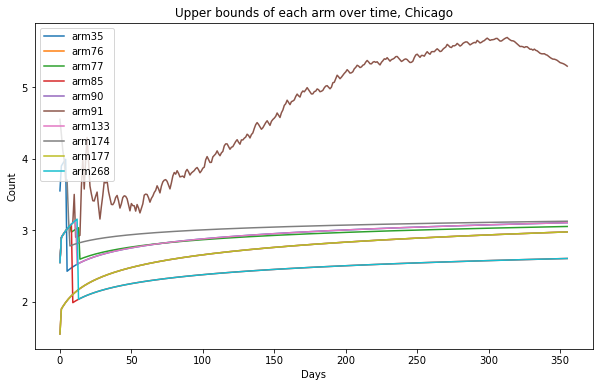

In [362]:
plt.figure(figsize=(10,6))
plt.plot(upper_bounds_hist)
plt.ylabel("Count")
plt.xlabel("Days")
plt.title("Upper bounds of each arm over time, Chicago")
plt.legend(["arm35","arm76","arm77","arm85","arm90","arm91","arm133","arm174","arm177","arm268"])
plt.show()

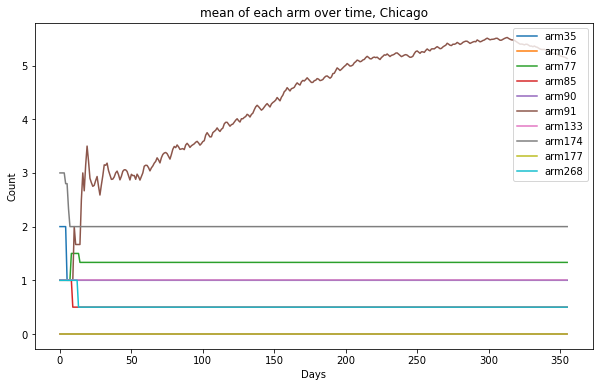

In [363]:
plt.figure(figsize=(10,6))
plt.plot(mean_record)
plt.ylabel("Count")
plt.xlabel("Days")
plt.title("mean of each arm over time, Chicago")
plt.legend(["arm35","arm76","arm77","arm85","arm90","arm91","arm133","arm174","arm177","arm268"], loc = 'upper right')
plt.show()

In [364]:
print("================================================================")
print("total reward gain by this modified UCB algorithm  : ", total_reward)
print("================================================================")
print("total regret by this modified UCB algorithm       : ", regret_over_time[-1])
print("================================================================")
print("Theoretical maximum to achieved(0 regret)         : ", 3857.0)
print("================================================================")
print("Regret Rate                                       : ", regret_over_time[-1]/3857)
print("================================================================")
print("Reward Rate                                       : ", total_reward/3857)

total reward gain by this modified UCB algorithm  :  1789.0
total regret by this modified UCB algorithm       :  2056.839999999984
Theoretical maximum to achieved(0 regret)         :  3857.0
Regret Rate                                       :  0.5332745657246523
Reward Rate                                       :  0.4638319937775473


### Recap
**Performance:** Poor
* As we can see from the above result summary, the algorithm does not perform ideally, since it only captures around half of the reward. <br/>


**Reasoning:**
* The reason why it doesn't work well at Chicago is pretty obvious: The reward distribution of the arms are not normal. In other words, the best arm (ARM35) behaves poorly at the beginning, but boost up towards the end of the year. <br/>
* Whereas, the arm that pulled most often(ARM 91) behaves very nice at the beginning, and "tricked" the system to select it, though its performance gets poorer towards the end. That's also the reason why we seeing the Regret graph has a steeper slope towards the end of the year.
* The graph below shows the details, it's displaying the reward of each arm versas time
    * We can see the arm35 performed poorly until March/April in 2016, but started be "outstanding" in June and July. 
    * Where as Arm 91 was performing well enough in the beginning, and "cheat" the algorithm to pull it all the way.
    * A theoretical way to explain what's happening: The assumption of each arm's rewards is normally distributed is voilated

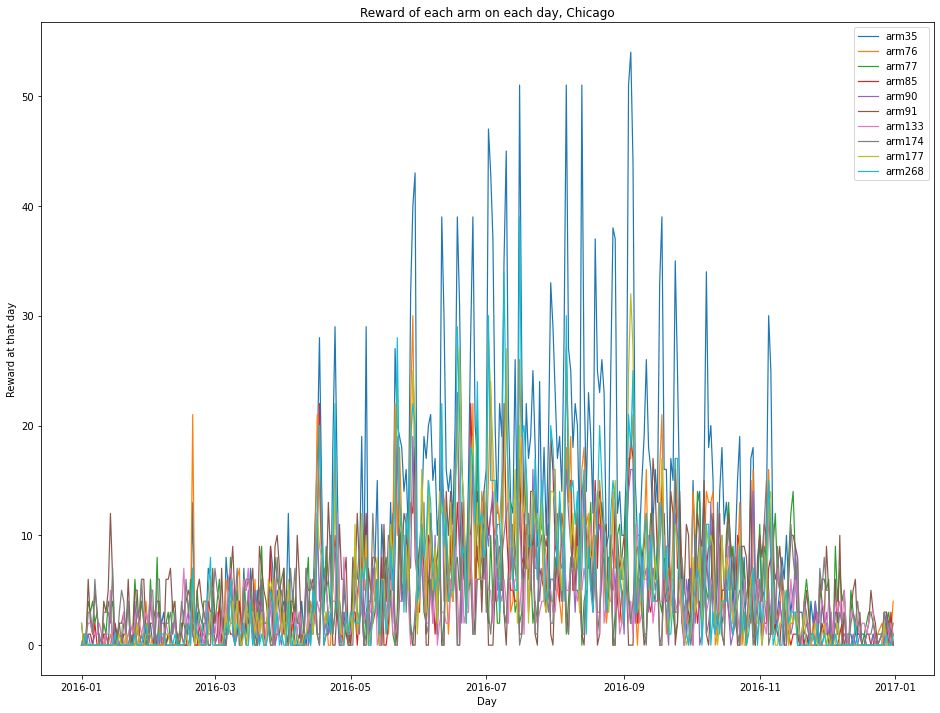

In [154]:
plt.figure(figsize=(16, 12))
plt.plot(df, linewidth = 1.2)
plt.ylabel("Reward at that day")
plt.xlabel("Day")
plt.title("Reward of each arm on each day, Chicago")
plt.legend(["arm35","arm76","arm77","arm85","arm90","arm91","arm133","arm174","arm177","arm268"], loc = 'upper right')
plt.show()

## Similar method applied in NY
Though not very successful in Chicago, we still respect the efficiency of algorithm, and hopefully NY's data will be more aligned with our assumptions, and have better performance.

In [249]:
## Load the data and some basic featuring
ny_df = pd.read_csv("../data/bikeshare/ny.csv")
ny_df = ny_df.iloc[:,[0,1,3,7,]]
ny_df.columns = ["trip_id","starttime" ,"from_station_id", "to_station_id"]

In [250]:
from_station = ny_df.groupby("from_station_id")["trip_id"].count()
to_station = ny_df.groupby("to_station_id")["trip_id"].count()

In [251]:
station_total = pd.merge(pd.DataFrame(from_station), pd.DataFrame(to_station), left_index=True, right_index=True)
station_total.reset_index(inplace=True)
station_total["station_total"] = station_total["trip_id_x"] + station_total["trip_id_y"]
station_total.columns = ["station_id", "#from_trips", "#to_trips", "station_total"]
#station_total.head()
print("finish getting total rentals in each station")

## get the first 10
first_ten = station_total.sort_values(by ='station_total', ascending= False)[:10]
#first_ten = first_ten.reset_index()
print("Ten busiest stations in Chicago")
first_ten

finish getting total rentals in each station
Ten busiest stations in Chicago


,station_id,#from_trips,#to_trips,station_total
286,519,2968,2977,5945
265,497,2085,2069,4154
206,435,1991,2062,4053
199,426,1974,2050,4024
179,402,1896,2072,3968
258,490,1719,1732,3451
77,285,1661,1748,3409
15,151,1642,1660,3302
281,514,1597,1705,3302
76,284,1622,1675,3297


**Now, construct df of total rentals of these 10 stations on each day of the year.**

In [252]:
ny_df['starttime_pd'] = pd.to_datetime(ny_df['starttime'])
ny_df['date'] = ny_df['starttime_pd'].dt.date
station_list = list(first_ten["station_id"])
curr = ny_df[ny_df["from_station_id"].isin(station_list)]
curr = curr.groupby(["date","from_station_id"])["trip_id"].count()
curr = pd.DataFrame(curr)
temp = pd.pivot_table(curr, index= "date" , values=['trip_id'],columns= ['from_station_id'],aggfunc='sum')
from_station = temp.fillna(0)
#from_station.head()

curr_2 = ny_df[ny_df["to_station_id"].isin(station_list)]
curr_2 = curr_2.groupby(["date","to_station_id"])["trip_id"].count()
curr_2 = pd.DataFrame(curr_2)
temp = pd.pivot_table(curr_2, index= "date" , values=['trip_id'],columns= ['to_station_id'],aggfunc='sum')
to_station = temp.fillna(0)
#to_station.head(6)

In [253]:
temp = pd.pivot_table(curr, index= "date" , values=['trip_id'],columns= ['from_station_id'],aggfunc='sum')
from_station = temp.fillna(0)

temp = pd.pivot_table(curr_2, index= "date" , values=['trip_id'],columns= ['to_station_id'],aggfunc='sum')
to_station = temp.fillna(0)


from_station.columns = [col[0] + "_from_" + str(col[1]) for col in from_station.columns.ravel()]
to_station.columns = [col[0] + "_to_" + str(col[1]) for col in to_station.columns.ravel()]
df = pd.merge(from_station, to_station, left_index = True, right_index = True, how = "outer")
df.fillna(0, inplace = True)

for i in [519, 497, 435, 426, 402, 490, 285, 151, 514, 284]:
    df['sum_col_' + str(i)] = df['trip_id_from_' + str(i)] + df['trip_id_to_' + str(i)]
df = df.iloc[:,20:30]
df.head(10)

,sum_col_519,sum_col_497,sum_col_435,sum_col_426,sum_col_402,sum_col_490,sum_col_285,sum_col_151,sum_col_514,sum_col_284
date,,,,,,,,,,
2016-01-01,2.0,1.0,5.0,3.0,0.0,1.0,2.0,3.0,1.0,4.0
2016-01-02,5.0,5.0,4.0,2.0,6.0,6.0,5.0,3.0,3.0,4.0
2016-01-03,4.0,4.0,9.0,1.0,2.0,1.0,3.0,6.0,2.0,6.0
2016-01-04,9.0,4.0,11.0,2.0,10.0,4.0,6.0,5.0,2.0,2.0
2016-01-05,12.0,5.0,6.0,2.0,6.0,7.0,5.0,4.0,0.0,3.0
2016-01-06,17.0,12.0,9.0,4.0,5.0,8.0,10.0,4.0,4.0,5.0
2016-01-07,15.0,8.0,10.0,4.0,8.0,10.0,6.0,6.0,2.0,7.0
2016-01-08,10.0,11.0,9.0,6.0,8.0,7.0,8.0,7.0,2.0,4.0
2016-01-09,7.0,13.0,5.0,11.0,7.0,2.0,5.0,4.0,2.0,4.0


* To avoid the mistake made in Chicago, let's plot the reward of each arm over time to see if assumptions are violoated in the first place. <br/>Looks like NY's arms' performances much more "consistent" over time

* Also, instead initialize by turnm we initialize the reward by mean of first 20 days

In [254]:
df.iloc[:20,:].mean(axis = 0)

sum_col_519    8.40
sum_col_497    7.65
sum_col_435    7.15
sum_col_426    4.05
sum_col_402    5.65
sum_col_490    5.75
sum_col_285    5.80
sum_col_151    5.15
sum_col_514    2.15
sum_col_284    3.90
dtype: float64

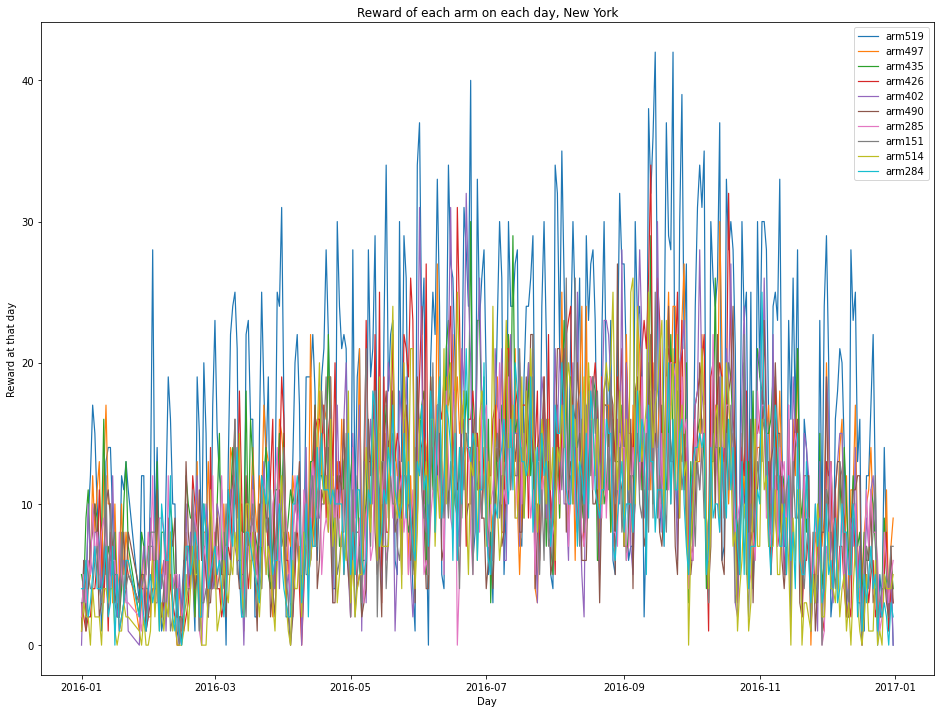

In [255]:
plt.figure(figsize=(16, 12))
plt.plot(df, linewidth = 1.2)
plt.ylabel("Reward at that day")
plt.xlabel("Day")
plt.title("Reward of each arm on each day, New York")
plt.legend(["arm519","arm497","arm435","arm426","arm402","arm490","arm285","arm151","arm514","arm284"], loc = 'upper right')
plt.show()

In [319]:
def update_UCB_arm_ny():
    ## initialize the best reward
    best_reward = 16.4
    
    ### initialize by pulling all arms once
    num_times_pulled = np.array([1,1,1,1,1,1,1,1,1,1])
    pull_record = [num_times_pulled.copy()]
    
    ### the reward got by the first pull
    total_reward_gain = np.array([8.4,7.65,7.15,4.05,5.65,5.75,5.8,5.15,2.15,3.9])
    
    ### temp helper
    mu_over_time = total_reward_gain/num_times_pulled
    ### mean record
    mean_record = [mu_over_time.copy()]
    
    ### store the initial upper bound, at time 11 
    upper_bounds = mu_over_time + ((3*math.log(11))/(2*num_times_pulled))**(1/2)
    upper_bounds_hist = [upper_bounds.copy()]
    
    ### initialize the regret
    regret = 328 - 102
    cum_regret = [328 - 102]
    
    total_reward = 102
    
    ## Start iteration from the 11th pull, index 10
    for i in range(20,362):
        arm_to_pull = np.argmax(upper_bounds)
        num_times_pulled[arm_to_pull] += 1
        ## record
        pull_record.append(num_times_pulled.copy())
        
        total_reward_gain[arm_to_pull] += df.iloc[i ,arm_to_pull]
        
        total_reward += df.iloc[i ,arm_to_pull]
        
        ## mu to update
        new_mu = (total_reward_gain[arm_to_pull]/num_times_pulled[arm_to_pull])
        mu_over_time[arm_to_pull] = new_mu
        mean_record.append(mu_over_time.copy())
        
        upper_bounds = mu_over_time + ((3*math.log(i+1))/(2*num_times_pulled))**(1/2)
        ##upper_bounds[arm_to_pull] = new_mu + ((3*math.log(i+1))/(2*num_times_pulled[arm_to_pull]*i))**(1/2)
        ## record
        upper_bounds_hist.append(upper_bounds.copy())
        
        if arm_to_pull != 0:
            regret += best_reward - df.iloc[i ,arm_to_pull]
            cum_regret.append(regret)
        else:
            regret += 0
            cum_regret.append(regret)
            
            #cum_regret.append()
    
    return pull_record, mean_record, upper_bounds_hist, cum_regret, total_reward

In [320]:
pull_record, mean_record, upper_bounds_hist, regret_over_time, total_reward = update_UCB_arm_ny()

In [321]:
pull_record = pd.DataFrame(pull_record)
upper_bounds_hist = pd.DataFrame(upper_bounds_hist)
mean_record = pd.DataFrame(mean_record)

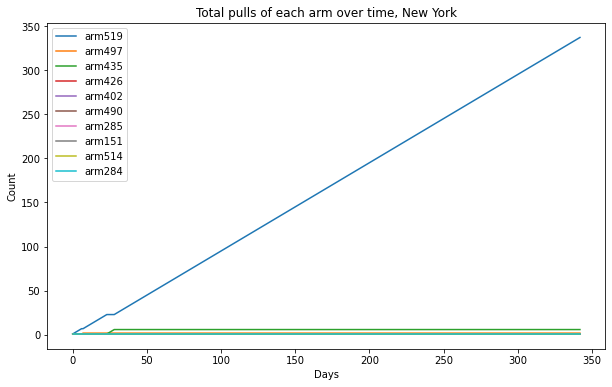

In [322]:
plt.figure(figsize=(10,6))
plt.plot(pull_record)
plt.ylabel("Count")
plt.xlabel("Days")
plt.title("Total pulls of each arm over time, New York")
plt.legend(["arm519","arm497","arm435","arm426","arm402","arm490","arm285","arm151","arm514","arm284"])
plt.show()

Text(0.5, 0, 'Days')

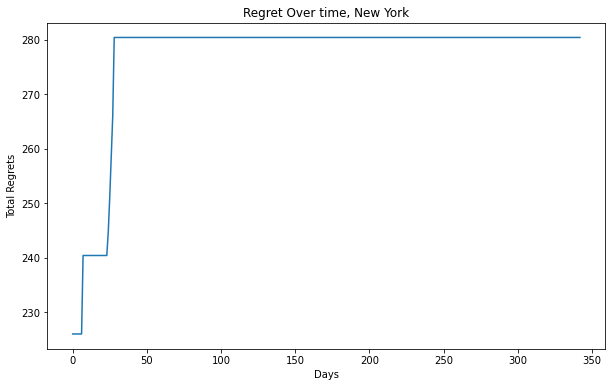

In [323]:
plt.figure(figsize=(10,6))
plt.plot(regret_over_time)
plt.title("Regret Over time, New York")
plt.ylabel("Total Regrets")
plt.xlabel("Days")

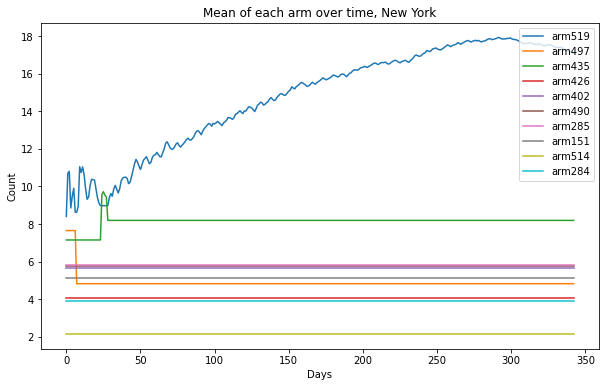

In [324]:
plt.figure(figsize=(10,6))
plt.plot(mean_record)
plt.ylabel("Count")
plt.xlabel("Days")
plt.title("Mean of each arm over time, New York")
plt.legend(["arm519","arm497","arm435","arm426","arm402","arm490","arm285","arm151","arm514","arm284"], loc = "upper right")
plt.show()

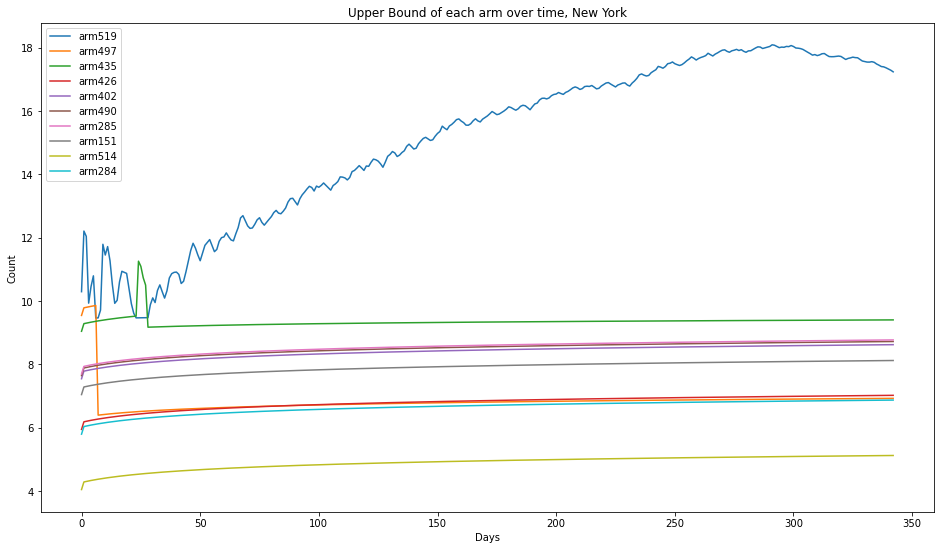

In [325]:
plt.figure(figsize=(16,9))
plt.plot(upper_bounds_hist)
plt.ylabel("Count")
plt.xlabel("Days")
plt.title("Upper Bound of each arm over time, New York")
plt.legend(["arm519","arm497","arm435","arm426","arm402","arm490","arm285","arm151","arm514","arm284"])
plt.show()

In [331]:
print("================================================================")
print("total reward gain by this modified UCB algorithm  : ", total_reward)
print("================================================================")
print("total regret by this modified UCB algorithm       : ", regret_over_time[-1])
print("================================================================")
print("Theoretical maximum to achieved(0 regret)         : ", 5945.0)
print("================================================================")
print("Regret Rate                                       : ", regret_over_time[-1]/5945)
print("================================================================")
print("Reward Rate                                       : ", total_reward/5945)

total reward gain by this modified UCB algorithm  :  5893.0
total regret by this modified UCB algorithm       :  280.4
Theoretical maximum to achieved(0 regret)         :  5945.0
Regret Rate                                       :  0.047165685449957945
Reward Rate                                       :  0.9912531539108494


### Recap
**Performance:** Very Strong
* As we can see from the above result summary, the algorithm does not very nice, achieving almost no regrets. <br/>


**Reasoning: A few reasons why it's performing much better than the Chicago case**
* Compared to Chicago, the rewards of arms in New York are performing much more consistent. No arms are performing very differently during the year. 
* An improved initialization method works nice, instead of only deciding the initial condition by a random  day in first 10 days, I took the average of first 20 days, theoretically it should reduces the variance/risk by 400 times. And as expected, UCB algorithm perform a much more reliable performance this time. 
* The cost to this method is a much higher expense at the Exploration, that's 20 times to the Chicago's Exploration Cost.

## UCB at Washington D.C.
Finally, we will also explore the performance of the algorithm in DC

In [332]:
## load the data
dc_df = pd.read_csv("../data/bikeshare/dc.csv")
dc_df = dc_df.iloc[:,[0,1,3,5]]
dc_df.columns = ["trip_id","starttime" ,"from_station_id", "to_station_id"]
from_station = dc_df.groupby("from_station_id")["trip_id"].count()
to_station = dc_df.groupby("to_station_id")["trip_id"].count()

In [333]:
station_total = pd.merge(pd.DataFrame(from_station), pd.DataFrame(to_station), left_index=True, right_index=True)
station_total.reset_index(inplace=True)
station_total["station_total"] = station_total["trip_id_x"] + station_total["trip_id_y"]
station_total.columns = ["station_id", "#from_trips", "#to_trips", "station_total"]
#station_total.head()
print("finish getting total rentals in each station")

## get the first 10
first_ten = station_total.sort_values(by ='station_total', ascending= False)[:10]
#first_ten = first_ten.reset_index()
print("Ten busiest stations in Chicago")
first_ten

finish getting total rentals in each station
Ten busiest stations in Chicago


,station_id,#from_trips,#to_trips,station_total
290,31623,1388,1443,2831
182,31258,1210,1148,2358
171,31247,1145,1135,2280
125,31200,1090,1171,2261
126,31201,819,878,1697
173,31249,692,762,1454
101,31101,728,725,1453
165,31241,745,693,1438
153,31229,675,708,1383
280,31613,637,646,1283


In [334]:
dc_df['starttime_pd'] = pd.to_datetime(dc_df['starttime'])
dc_df['date'] = dc_df['starttime_pd'].dt.date
station_list = list(first_ten["station_id"])
curr = dc_df[dc_df["from_station_id"].isin(station_list)]
curr = curr.groupby(["date","from_station_id"])["trip_id"].count()
curr = pd.DataFrame(curr)
temp = pd.pivot_table(curr, index= "date" , values=['trip_id'],columns= ['from_station_id'],aggfunc='sum')
from_station = temp.fillna(0)
#from_station.head()

curr_2 = dc_df[dc_df["to_station_id"].isin(station_list)]
curr_2 = curr_2.groupby(["date","to_station_id"])["trip_id"].count()
curr_2 = pd.DataFrame(curr_2)
temp = pd.pivot_table(curr_2, index= "date" , values=['trip_id'],columns= ['to_station_id'],aggfunc='sum')
to_station = temp.fillna(0)
#to_station.head(6)

In [335]:
temp = pd.pivot_table(curr, index= "date" , values=['trip_id'],columns= ['from_station_id'],aggfunc='sum')
from_station = temp.fillna(0)

temp = pd.pivot_table(curr_2, index= "date" , values=['trip_id'],columns= ['to_station_id'],aggfunc='sum')
to_station = temp.fillna(0)


from_station.columns = [col[0] + "_from_" + str(col[1]) for col in from_station.columns.ravel()]
to_station.columns = [col[0] + "_to_" + str(col[1]) for col in to_station.columns.ravel()]
df = pd.merge(from_station, to_station, left_index = True, right_index = True, how = "outer")
df.fillna(0, inplace = True)

for i in [31623, 31258, 31247, 31200, 31201, 31249, 31101, 31241, 31229, 31613]:
    df['sum_col_' + str(i)] = df['trip_id_from_' + str(i)] + df['trip_id_to_' + str(i)]
df = df.iloc[:,20:30]
df.head(10)

,sum_col_31623,sum_col_31258,sum_col_31247,sum_col_31200,sum_col_31201,sum_col_31249,sum_col_31101,sum_col_31241,sum_col_31229,sum_col_31613
date,,,,,,,,,,
2016-01-01,4.0,3.0,0.0,3.0,0.0,2.0,2.0,0.0,0.0,1.0
2016-01-02,1.0,5.0,3.0,5.0,7.0,3.0,1.0,0.0,3.0,5.0
2016-01-03,0.0,4.0,7.0,2.0,4.0,4.0,4.0,1.0,2.0,1.0
2016-01-04,6.0,1.0,1.0,4.0,4.0,1.0,3.0,3.0,6.0,4.0
2016-01-05,9.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,5.0,3.0
2016-01-06,7.0,0.0,1.0,5.0,3.0,1.0,4.0,1.0,2.0,5.0
2016-01-07,10.0,0.0,1.0,5.0,2.0,0.0,0.0,9.0,3.0,2.0
2016-01-08,11.0,0.0,4.0,7.0,2.0,0.0,4.0,2.0,4.0,3.0
2016-01-09,7.0,4.0,3.0,5.0,3.0,2.0,0.0,5.0,6.0,2.0


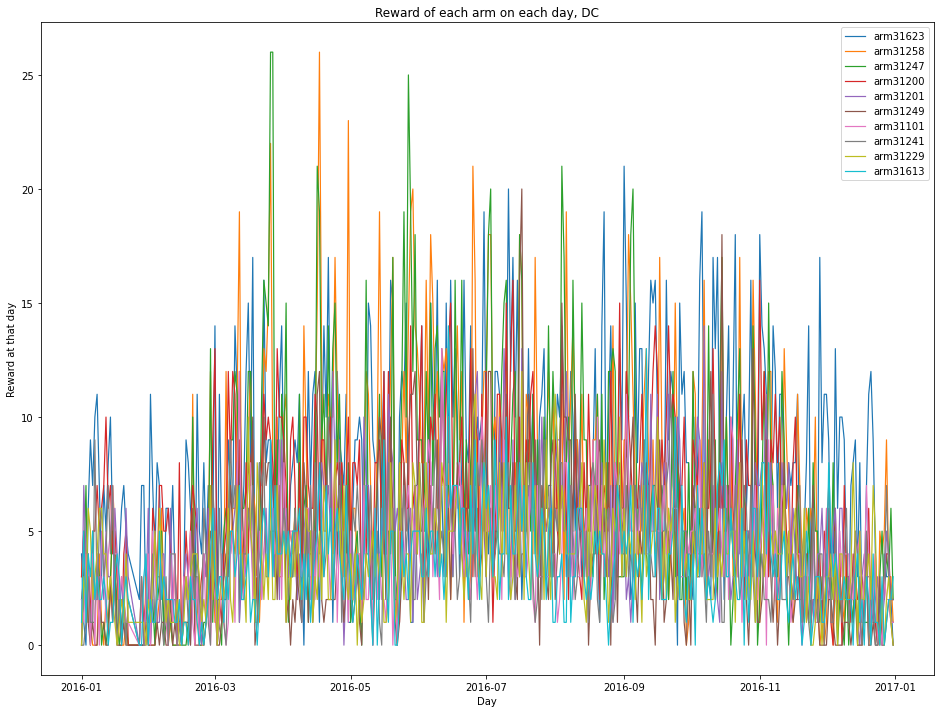

In [336]:
plt.figure(figsize=(16, 12))
plt.plot(df, linewidth = 1.2)
plt.ylabel("Reward at that day")
plt.xlabel("Day")
plt.title("Reward of each arm on each day, DC")
plt.legend(["arm31623","arm31258","arm31247","arm31200","arm31201","arm31249","arm31101","arm31241","arm31229","arm31613"], loc = 'upper right')
plt.show()

In [337]:
df.iloc[:10,:].mean(axis = 0)

sum_col_31623    5.8
sum_col_31258    1.9
sum_col_31247    2.1
sum_col_31200    4.3
sum_col_31201    2.8
sum_col_31249    1.4
sum_col_31101    2.3
sum_col_31241    2.8
sum_col_31229    3.7
sum_col_31613    2.8
dtype: float64

In [338]:
def update_UCB_arm_dc():
    ## initialize the best reward
    best_reward = 7.8
    
    ### initialize by pulling all arms once
    num_times_pulled = np.array([1,1,1,1,1,1,1,1,1,1])
    pull_record = [num_times_pulled.copy()]
    
    ### the reward got by the first pull
    total_reward_gain = np.array([5.8, 1.9, 2.1, 4.3, 2.8, 1.4, 2.3, 2.8, 3.7, 2.8])
    
    ### temp helper
    mu_over_time = total_reward_gain/num_times_pulled
    ### mean record
    mean_record = [mu_over_time.copy()]
    
    ### store the initial upper bound, at time 11 
    upper_bounds = mu_over_time + ((3*math.log(11))/(2*num_times_pulled))**(1/2)
    upper_bounds_hist = [upper_bounds.copy()]
    
    ### initialize the regret
    regret = 78 - 29.9
    cum_regret = [78 - 29.9]
    
    total_reward = 29.9
    
    
    ## Start iteration from the 11th pull, index 10
    for i in range(10,362):
        arm_to_pull = np.argmax(upper_bounds)
        num_times_pulled[arm_to_pull] += 1
        ## record
        pull_record.append(num_times_pulled.copy())
        
        total_reward_gain[arm_to_pull] += df.iloc[i ,arm_to_pull]
        
        total_reward += df.iloc[i ,arm_to_pull]
        
        ## mu to update
        new_mu = (total_reward_gain[arm_to_pull]/num_times_pulled[arm_to_pull])
        mu_over_time[arm_to_pull] = new_mu
        mean_record.append(mu_over_time.copy())
        
        upper_bounds = mu_over_time + ((3*math.log(i+1))/(2*num_times_pulled))**(1/2)
        ##upper_bounds[arm_to_pull] = new_mu + ((3*math.log(i+1))/(2*num_times_pulled[arm_to_pull]*i))**(1/2)
        ## record
        upper_bounds_hist.append(upper_bounds.copy())
        
        if arm_to_pull != 0:
            regret += best_reward - df.iloc[i ,arm_to_pull]
            cum_regret.append(regret)
        else:
            regret += 0
            cum_regret.append(regret)
            
            #cum_regret.append()
    
    return pull_record, mean_record, upper_bounds_hist, cum_regret, total_reward

In [339]:
pull_record, mean_record, upper_bounds_hist, regret_over_time, total_reward = update_UCB_arm_dc()
pull_record = pd.DataFrame(pull_record)
upper_bounds_hist = pd.DataFrame(upper_bounds_hist)
mean_record = pd.DataFrame(mean_record)

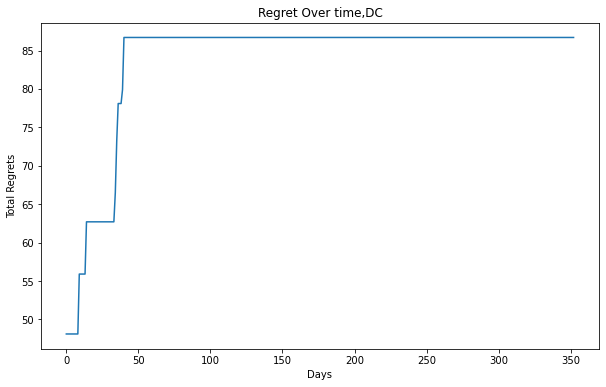

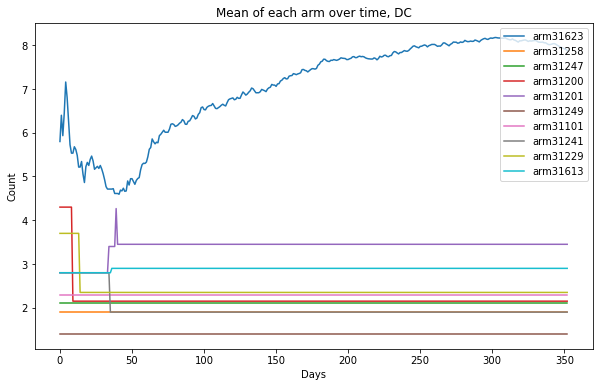

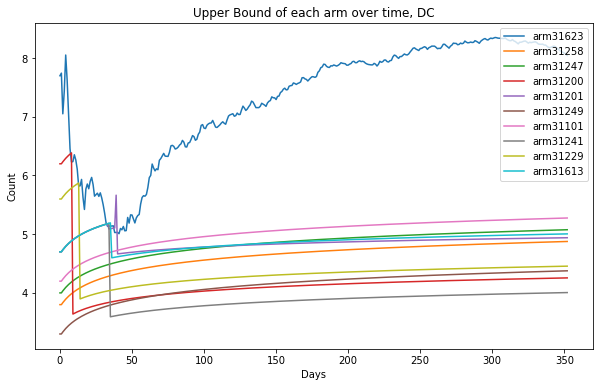

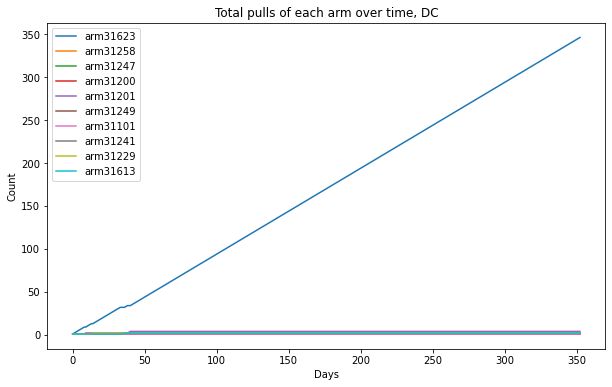

In [340]:
plt.figure(figsize=(10,6))
plt.plot(regret_over_time)
plt.title("Regret Over time,DC")
plt.ylabel("Total Regrets")
plt.xlabel("Days")

plt.figure(figsize=(10,6))
plt.plot(mean_record)
plt.ylabel("Count")
plt.xlabel("Days")
plt.title("Mean of each arm over time, DC")
plt.legend(["arm31623","arm31258","arm31247","arm31200","arm31201","arm31249","arm31101","arm31241","arm31229","arm31613"], loc = "upper right")
plt.show()

plt.figure(figsize=(10,6))
plt.plot(upper_bounds_hist)
plt.ylabel("Count")
plt.xlabel("Days")
plt.title("Upper Bound of each arm over time, DC")
plt.legend(["arm31623","arm31258","arm31247","arm31200","arm31201","arm31249","arm31101","arm31241","arm31229","arm31613"], loc = "upper right")
plt.show()

plt.figure(figsize=(10,6))
plt.plot(pull_record)
plt.ylabel("Count")
plt.xlabel("Days")
plt.title("Total pulls of each arm over time, DC")
plt.legend(["arm31623","arm31258","arm31247","arm31200","arm31201","arm31249","arm31101","arm31241","arm31229","arm31613"])
plt.show()

In [343]:
print("================================================================")
print("total reward gain by this modified UCB algorithm  : ", total_reward)
print("================================================================")
print("total regret by this modified UCB algorithm       : ", regret_over_time[-1])
print("================================================================")
print("Theoretical maximum to achieved(0 regret)         : ", 2831.0)
print("================================================================")
print("Regret Rate                                       : ", regret_over_time[-1]/2831)
print("================================================================")
print("Reward Rate                                       : ", total_reward/2831)

total reward gain by this modified UCB algorithm  :  2766.9
total regret by this modified UCB algorithm       :  86.69999999999999
Theoretical maximum to achieved(0 regret)         :  2831.0
Regret Rate                                       :  0.030625220770045918
Reward Rate                                       :  0.9773578240904275


### Recap
**Performance:** Very Strong
* As we can see from the above result summary, the algorithm does not very nice, achieving almost no regrets. <br/>


**Reasoning: Similar to NY's case**

# An overall summary of three city

**Chicago**: 
* Performance          : Poor; 
* Reward Rate          : Low;        
* Exploration Cost     : Low;        
* Data Fit Assumption? : Bad;

**New York**: 
* Performance          : Very Well; 
* Reward Rate          : High;        
* Exploration Cost     : High;        
* Data Fit Assumption? : Almost Good;

**Washington D.C.**: 
* Performance          : Very Well; 
* Reward Rate          : High;        
* Exploration Cost     : Medium;        
* Data Fit Assumption? : Good;

# Future Work


* As you might have noticed, there's a lot of factors that could affect the performance of the Bandit Simulation method. I just listed a few of them above, like how good the data corresponds to normal distr, how to handle the "Exploration & Exploitation Trade-off". There's a lot more factor to tuned to optimize the model. 
* A general rule of thumb is, if the data fits the assumptions well, we can leverage less expense on exploration; whereas, if the data doesn't fit the assumptions well, we shall probably spend more in exploration.
    * For example, Chicago has a very bad performance, not simply due to the rewards of arms are not consistent over time, but also a poor cost on exploration. If we spend more on exploration(should be more than NY), Chicago can still achieve a reasonable Reward Rate finally. That's something very interesting to research on in the future.